# Импорт библиотек

In [1]:
from tqdm import tqdm
import torch.nn as nn
import time
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
from torchvision import transforms as tfs
import tqdm

# Структура нейросети и функций подсчета метрик

In [2]:
class DigitSegmentationNet(nn.Module):
    def __init__(self, num_classes=11):
        super(DigitSegmentationNet, self).__init__()

        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.dec4 = self.up_conv_block(512, 256)
        self.dec3 = self.up_conv_block(512, 128)
        self.dec2 = self.up_conv_block(256, 64)
        self.dec1 = self.up_conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def up_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        d4 = self.dec4(e4)
        d3 = self.dec3(torch.cat([self.upsample(d4), e3], 1))
        d2 = self.dec2(torch.cat([self.upsample(d3), e2], 1))
        d1 = self.dec1(torch.cat([self.upsample(d2), e1], 1))

        out = self.final_conv(d1)

        return out

In [3]:
def calculate_metrics(pred, target, num_classes=11):
    with torch.no_grad():
        pred_classes = torch.argmax(pred, dim=1)

        accuracy = (pred_classes == target).float().mean()

        iou_per_class = []
        for class_id in range(num_classes):
            pred_mask = (pred_classes == class_id)
            target_mask = (target == class_id)

            intersection = (pred_mask & target_mask).float().sum()
            union = (pred_mask | target_mask).float().sum()

            if union > 0:
                iou = intersection / union
                iou_per_class.append(iou.item())
            else:
                iou_per_class.append(float('nan'))

        valid_ious = [iou for iou in iou_per_class if not np.isnan(iou)]
        mean_iou = sum(valid_ious) / len(valid_ious) if valid_ious else 0

        return accuracy.item(), mean_iou

In [4]:
def plot_training_history(history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['val_losses'], label='Val Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['val_accuracies'], label='Val Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    ax3.plot(history['val_ious'], label='Val mIoU', color='red')
    ax3.set_title('Validation Mean IoU')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('mIoU')
    ax3.legend()
    ax3.grid(True)

    ax4.plot(history['val_accuracies'], label='Val Accuracy', alpha=0.7)
    ax4.plot(history['val_ious'], label='Val mIoU', alpha=0.7)
    ax4.set_title('Validation Metrics')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Score')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.show()


In [6]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    val_accuracies = []
    val_ious = []

    best_model_weights = None
    best_iou = 0.0

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        total_train_samples = 0

        train_pbar = tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, masks in train_pbar:
            images = images.to(device)
            masks = masks.to(device)

            batch_size = images.size(0)
            total_train_samples += batch_size

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * batch_size

            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        train_losses.append(epoch_train_loss / total_train_samples)

        model.eval()
        epoch_val_loss = 0
        epoch_val_acc = 0
        epoch_val_iou = 0
        total_val_samples = 0

        val_pbar = tqdm.tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        with torch.no_grad():
            for images, masks in val_pbar:
                images = images.to(device)
                masks = masks.to(device)

                batch_size = images.size(0)
                total_val_samples += batch_size

                outputs = model(images)
                loss = criterion(outputs, masks)
                epoch_val_loss += loss.item() * batch_size

                acc, iou = calculate_metrics(outputs, masks)
                epoch_val_acc += acc * batch_size
                epoch_val_iou += iou * batch_size

                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{acc:.4f}',
                    'IoU': f'{iou:.4f}'
                })

        val_loss = epoch_val_loss / total_val_samples
        val_acc = epoch_val_acc / total_val_samples
        val_iou = epoch_val_iou / total_val_samples

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_ious.append(val_iou)

        if val_iou > best_iou:
            best_iou = val_iou
            best_model_weights = model.state_dict().copy()
            print(f'New best model with IoU: {best_iou:.4f}')

        print(f'\nEpoch {epoch+1}/{num_epochs} Summary:')
        print(f'Train Loss: {train_losses[-1]:.4f}')
        print(f'Val Loss: {val_losses[-1]:.4f}')
        print(f'Val Acc: {val_accuracies[-1]:.4f}')
        print(f'Val mIoU: {val_ious[-1]:.4f}')
        print('-' * 50)

    history = {"train_losses": train_losses, 'val_losses': val_losses, 'val_accuracies': val_accuracies, 'val_ious': val_ious}
    plot_training_history(history)

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    return model

Загрузка датасетов, полученных в Multi Dataset Gen

In [7]:
!gdown 1QPHvDNKuuOjQfn_Mpj4czeMb2OmgFvf9 #train dataset

Downloading...
From (original): https://drive.google.com/uc?id=1QPHvDNKuuOjQfn_Mpj4czeMb2OmgFvf9
From (redirected): https://drive.google.com/uc?id=1QPHvDNKuuOjQfn_Mpj4czeMb2OmgFvf9&confirm=t&uuid=28ca5f65-9eb8-400e-a7e5-90bbae20830c
To: /content/multi_train_dataset.pt
100% 2.49G/2.49G [01:10<00:00, 35.1MB/s]


In [8]:
!gdown 1wrQ7Seql6LcJm4spdOgwwaVReQWEeN_6 #test dataset

Downloading...
From (original): https://drive.google.com/uc?id=1wrQ7Seql6LcJm4spdOgwwaVReQWEeN_6
From (redirected): https://drive.google.com/uc?id=1wrQ7Seql6LcJm4spdOgwwaVReQWEeN_6&confirm=t&uuid=1159214b-ca61-43a0-a919-4775fe2bcdd3
To: /content/multi_test_dataset.pt
100% 497M/497M [00:06<00:00, 73.1MB/s]


In [9]:
train_data = torch.load('multi_train_dataset.pt')
test_data = torch.load('multi_test_dataset.pt')

In [10]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Обучение

In [13]:
model = DigitSegmentationNet(num_classes=11)

Начинаем обучение...
Using device: cuda


Epoch 1/15 [Val]: 100%|██████████| 313/313 [00:09<00:00, 31.63it/s, Loss=0.0568, Acc=0.9962, IoU=0.9060]


New best model with IoU: 0.9232

Epoch 1/15 Summary:
Train Loss: 0.4141
Val Loss: 0.0508
Val Acc: 0.9966
Val mIoU: 0.9232
--------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 313/313 [00:09<00:00, 32.14it/s, Loss=0.0088, Acc=0.9995, IoU=0.9945]


New best model with IoU: 0.9618

Epoch 2/15 Summary:
Train Loss: 0.0237
Val Loss: 0.0133
Val Acc: 0.9982
Val mIoU: 0.9618
--------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 313/313 [00:09<00:00, 32.32it/s, Loss=0.0127, Acc=0.9983, IoU=0.8889]



Epoch 3/15 Summary:
Train Loss: 0.0085
Val Loss: 0.0135
Val Acc: 0.9970
Val mIoU: 0.9283
--------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 313/313 [00:09<00:00, 32.07it/s, Loss=0.0029, Acc=0.9991, IoU=0.9656]


New best model with IoU: 0.9774

Epoch 4/15 Summary:
Train Loss: 0.0047
Val Loss: 0.0044
Val Acc: 0.9990
Val mIoU: 0.9774
--------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 313/313 [00:09<00:00, 32.10it/s, Loss=0.0011, Acc=0.9998, IoU=0.9964]


New best model with IoU: 0.9823

Epoch 5/15 Summary:
Train Loss: 0.0032
Val Loss: 0.0029
Val Acc: 0.9992
Val mIoU: 0.9823
--------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 313/313 [00:09<00:00, 32.03it/s, Loss=0.0021, Acc=0.9986, IoU=0.8927]



Epoch 6/15 Summary:
Train Loss: 0.0025
Val Loss: 0.0029
Val Acc: 0.9992
Val mIoU: 0.9816
--------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 313/313 [00:09<00:00, 32.07it/s, Loss=0.0115, Acc=0.9959, IoU=0.8308]



Epoch 7/15 Summary:
Train Loss: 0.0021
Val Loss: 0.0032
Val Acc: 0.9991
Val mIoU: 0.9792
--------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 313/313 [00:09<00:00, 32.26it/s, Loss=0.0016, Acc=0.9989, IoU=0.8968]


New best model with IoU: 0.9885

Epoch 8/15 Summary:
Train Loss: 0.0016
Val Loss: 0.0018
Val Acc: 0.9995
Val mIoU: 0.9885
--------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 313/313 [00:09<00:00, 32.34it/s, Loss=0.0005, Acc=0.9999, IoU=0.9986]



Epoch 9/15 Summary:
Train Loss: 0.0015
Val Loss: 0.0023
Val Acc: 0.9993
Val mIoU: 0.9852
--------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 313/313 [00:09<00:00, 32.19it/s, Loss=0.0033, Acc=0.9980, IoU=0.8762]


New best model with IoU: 0.9903

Epoch 10/15 Summary:
Train Loss: 0.0013
Val Loss: 0.0014
Val Acc: 0.9996
Val mIoU: 0.9903
--------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 313/313 [00:09<00:00, 32.09it/s, Loss=0.0005, Acc=0.9999, IoU=0.9983]



Epoch 11/15 Summary:
Train Loss: 0.0012
Val Loss: 0.0021
Val Acc: 0.9995
Val mIoU: 0.9875
--------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 313/313 [00:09<00:00, 32.11it/s, Loss=0.0005, Acc=0.9999, IoU=0.9986]



Epoch 12/15 Summary:
Train Loss: 0.0011
Val Loss: 0.0019
Val Acc: 0.9995
Val mIoU: 0.9883
--------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 313/313 [00:09<00:00, 31.72it/s, Loss=0.0003, Acc=0.9998, IoU=0.9977]



Epoch 13/15 Summary:
Train Loss: 0.0010
Val Loss: 0.0023
Val Acc: 0.9994
Val mIoU: 0.9856
--------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 313/313 [00:09<00:00, 32.08it/s, Loss=0.0014, Acc=0.9998, IoU=0.9920]



Epoch 14/15 Summary:
Train Loss: 0.0009
Val Loss: 0.0036
Val Acc: 0.9991
Val mIoU: 0.9792
--------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 313/313 [00:09<00:00, 32.12it/s, Loss=0.0027, Acc=0.9985, IoU=0.8925]



Epoch 15/15 Summary:
Train Loss: 0.0009
Val Loss: 0.0038
Val Acc: 0.9990
Val mIoU: 0.9768
--------------------------------------------------


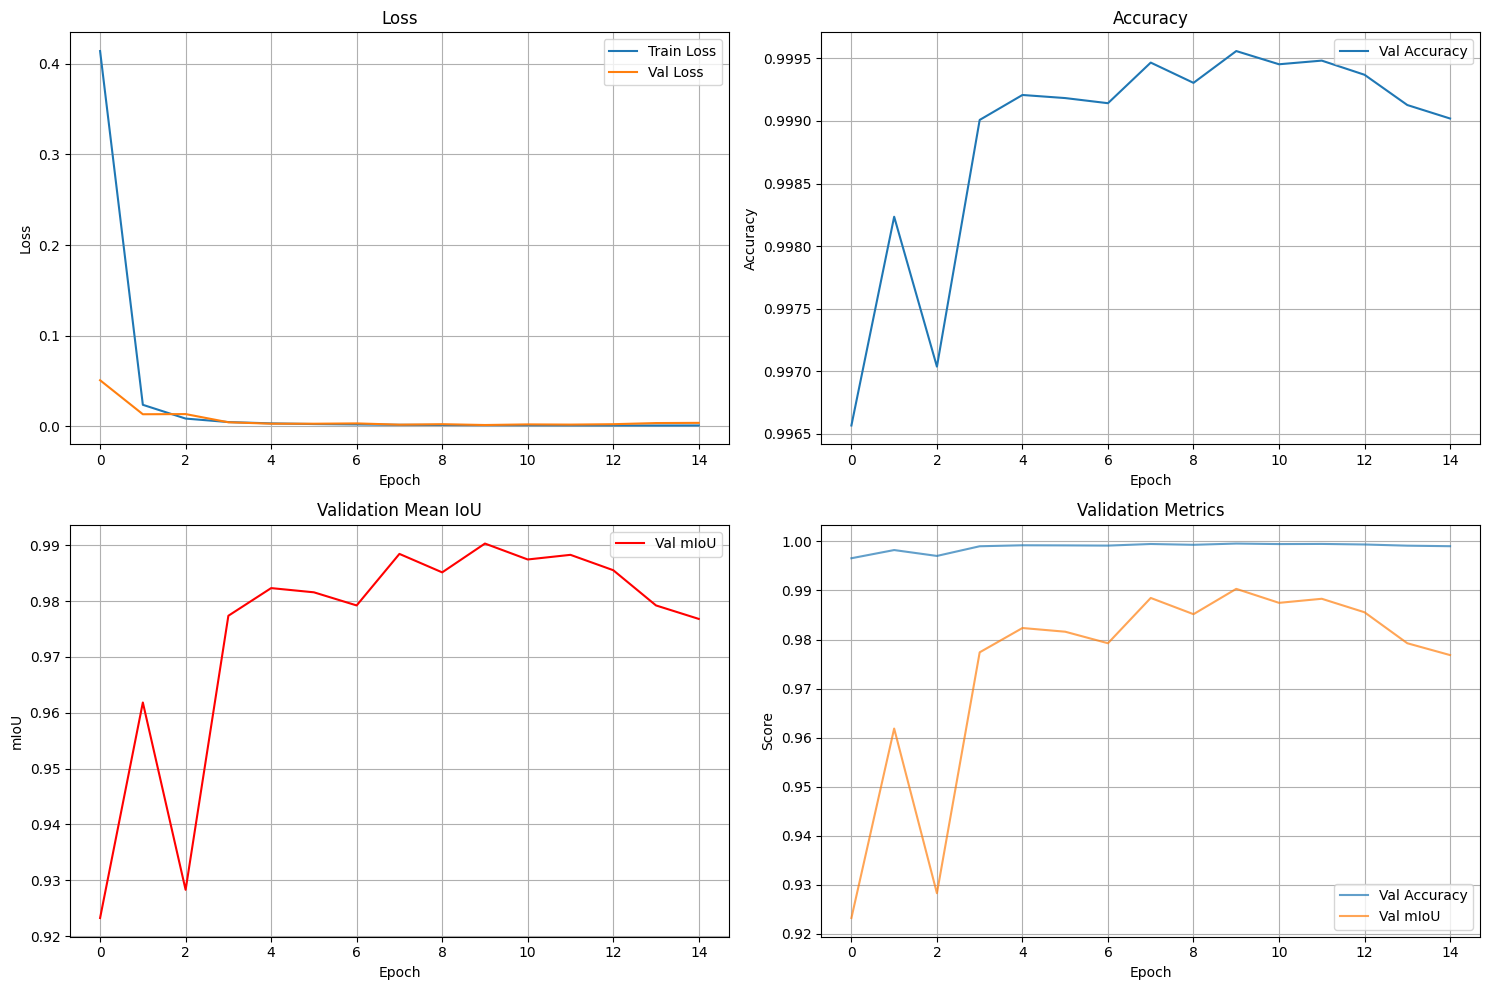

Обучение завершено! 🎉


In [14]:
print("Начинаем обучение...")
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=15
)

print("Обучение завершено! 🎉")

In [15]:
torch.save(model.state_dict(), 'model_weights.pth')